# Conditional spherical Gaussian experiment: inference results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [2]:
algo_filenames = [
    "flow",
    "pie",
    #"mf",
    #"gamf",
    #"mf_specified",
    # "pie_specified"
]
algo_additionals = [
    "",
    "",
    #"",
    #"", 
    #"", 
    # "", 
]
algo_labels = [
    "Flow",
    "PIE",
    #"Manifold flow (simple)",
    #"GAMF",
    #"Specified MF",
    #"Specified PIE"
]

setup_filenames = [
    "2_3_0.010",
    "2_3_0.001",
    "2_3_0.100",
]
setup_labels = [
    r"$\epsilon = 0.01$",
    r"$\epsilon = 0.001$",
    r"$\epsilon = 0.1$",
]


In [3]:
def load(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename in algo_filenames:
        results = []
        
        for setup_filename in setup_filenames:
            try:
                results.append(np.load(
                    "{}/{}_2_conditional_spherical_gaussian_{}_{}.npy".format(
                        result_dir, algo_filename, setup_filename, name
                    )
                ))
            except FileNotFoundError as e:
                print(e)
                results.append(np.nan*np.ones(shape))
            
        all_results.append(results)
    
    return np.asarray(all_results) if numpyfy else all_results

true_posterior_samples = load("true_posterior_samples", (1000,2))
model_posterior_samples = load("model_posterior_samples", (1000, 2))
mmds = load("mmd", (1,))

true_test_log_likelihood = load("true_log_likelihood_test", (11*11, 1000,))
model_test_log_likelihood = load("model_log_likelihood_test", (11*11, 1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))
parameter_grid = load("parameter_grid_test", (11*11,2))

model_test_log_likelihood.shape

(2, 3, 121, 1000)

In [4]:
x_test = np.asarray([
    np.load("../data/samples/conditional_spherical_gaussian/conditional_spherical_gaussian_{}_x_test.npy".format(setup_filename))
    for setup_filename in setup_filenames
])

true_distances = np.abs(np.sum(x_test**2, axis=-1)**0.5 - 1.)

In [5]:
true_expected_nll = -2. * np.mean(true_test_log_likelihood, axis=-1)
model_expected_nll = -2. * np.mean(model_test_log_likelihood, axis=-1)

n_observed = 20
true_observed_nll = -2. * np.sum(true_test_log_likelihood[:,:,:,:n_observed], axis=-1)
model_observed_nll = -2. * np.sum(model_test_log_likelihood[:,:,:,:n_observed], axis=-1)

## Plot eval likelihood on test samples

[0. 0.]


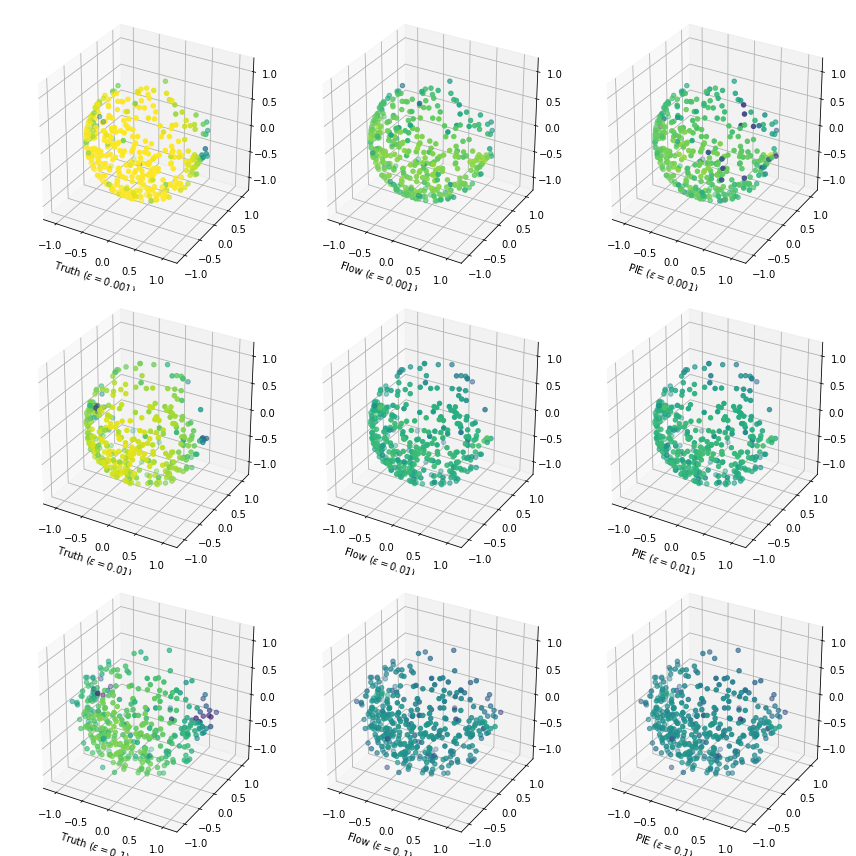

In [6]:
i_grid = 5*11 + 5
print(parameter_grid[0,0,i_grid])

cmin, cmax = -8., 7.
boundary = 1.2
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        x = x_test[setup, :400]
        logp = np.clip(
            true_test_log_likelihood[0, setup, i_grid, :400] if algo < 0 else model_test_log_likelihood[algo, setup, i_grid, :400],
            cmin, cmax
        )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, vmin=cmin, vmax=cmax, cmap="viridis")

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        ax.set_xlabel(("Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel("")
        ax.set_zlabel("")

plt.tight_layout()
plt.savefig("../figures/test_likelihood_3d_csg.pdf")


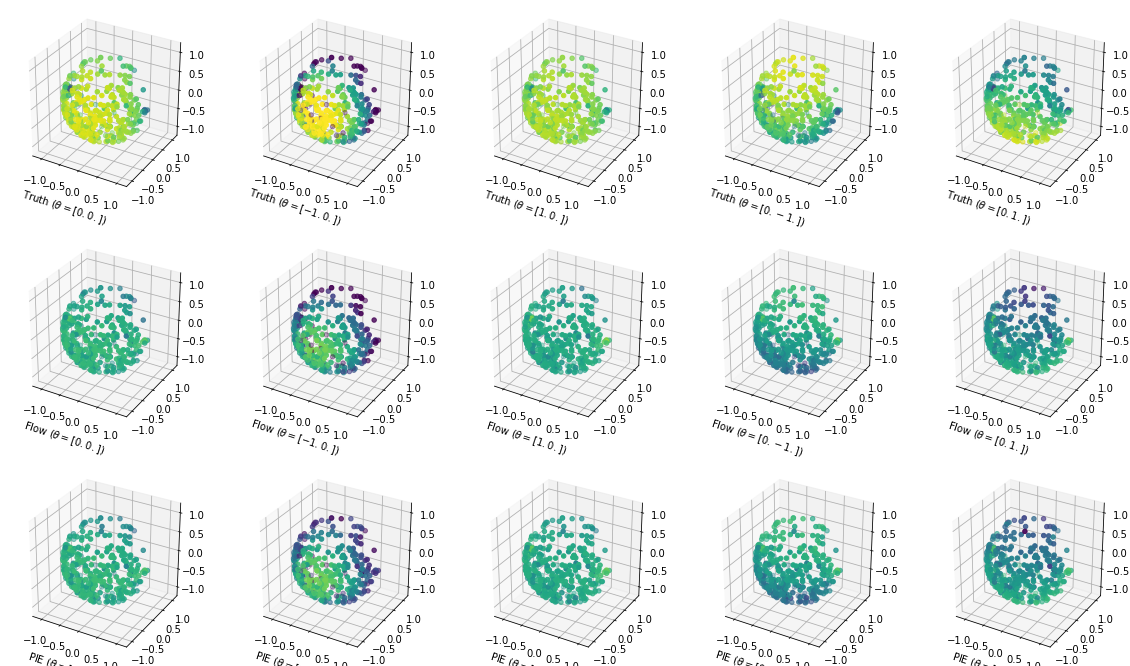

In [7]:
i_grids = [5*11 + 5, 0*11 + 5, 10*11 + 5, 5*11 + 0, 5*11 + 10]
setup = 0

cmin, cmax = -8., 7.
boundary = 1.2

nrows = len(algo_labels) + 1
ncols = len(i_grids)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, algo in enumerate(range(-1, len(algo_labels))):
    for col, i_grid in enumerate(i_grids):
        x = x_test[setup, :400]
        logp = np.clip(
            true_test_log_likelihood[0, setup, i_grid, :400] if algo < 0 else model_test_log_likelihood[algo, setup, i_grid, :400],
            cmin, cmax
        )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, vmin=cmin, vmax=cmax, cmap="viridis")

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        ax.set_xlabel(("Truth" if algo < 0 else algo_labels[algo]) + r" ($\theta = {}$)".format(parameter_grid[0,0,i_grid]))
        ax.set_ylabel("")
        ax.set_zlabel("")

# plt.tight_layout()
plt.savefig("../figures/test_likelihood_vs_params_3d_csg.pdf")

## Expected likelihood maps

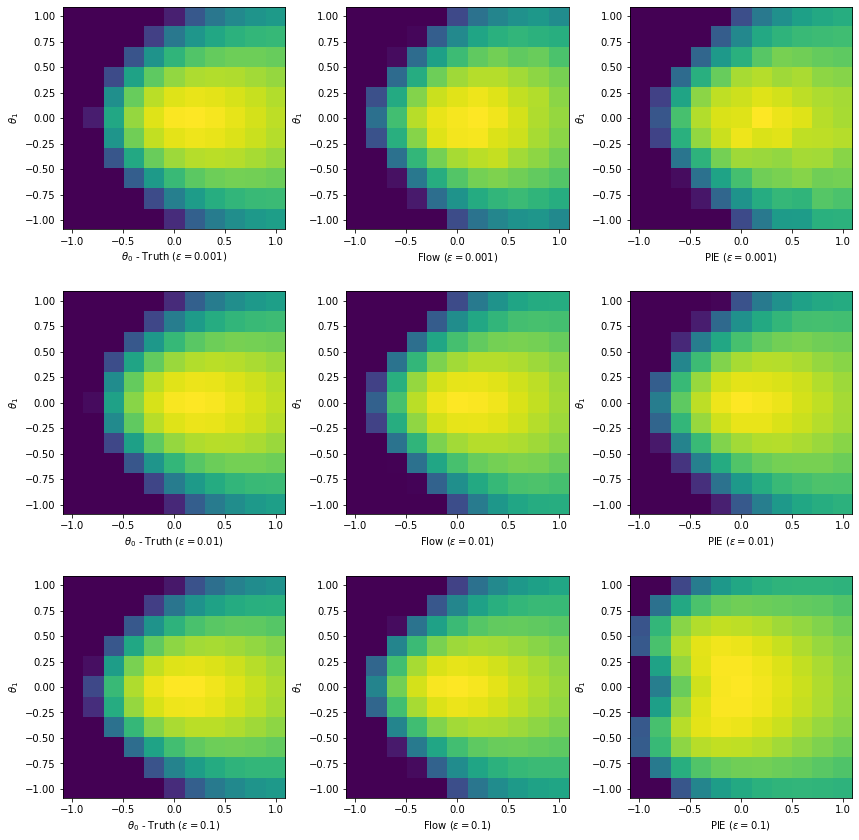

In [16]:
cmin, cmax = 0.,4.
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        logp = true_expected_nll[0, setup] if algo < 0 else model_expected_nll[algo, setup]
        logp = logp - np.min(logp)
        logp = np.clip(logp, cmin, cmax).reshape((11,11))
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1)
        extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)
        im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")

        ax.set_xlabel((r"$\theta_0$ - Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel(r"$\theta_1$")

plt.tight_layout()
plt.savefig("../figures/test_expected_likelihood_maps_csg.pdf")



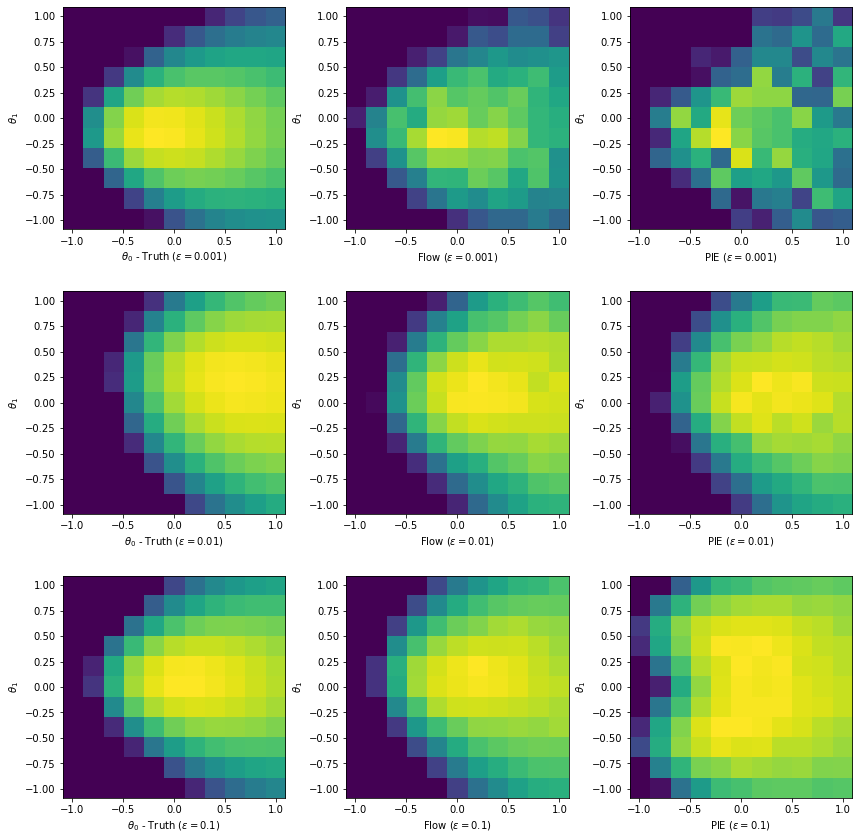

In [17]:
cmin, cmax = 0.,4.*n_observed
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        logp = true_observed_nll[0, setup] if algo < 0 else model_observed_nll[algo, setup]
        logp = logp - np.min(logp)
        logp = np.clip(logp, cmin, cmax).reshape((11,11))
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1)
        extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)
        im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")

        ax.set_xlabel((r"$\theta_0$ - Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel(r"$\theta_1$")

plt.tight_layout()
plt.savefig("../figures/test_observed_likelihood_maps_csg.pdf")




## Test likelihood scatter

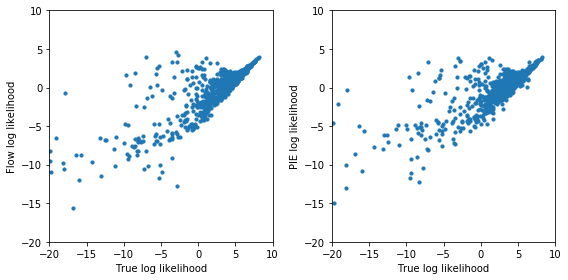

In [10]:
show = [0]
skip = 113

ncols = len(algo_labels)
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(algo_labels):
        ax = plt.subplot(nrows, ncols, setting*ncols + col + 1)
        sc = plt.scatter(
            true_test_log_likelihood[col, setting].flatten()[::skip],
            model_test_log_likelihood[col, setting].flatten()[::skip],
            # c=model_test_reco_error[col, setting].flatten(),
            s=10.,
            label=algo_label,
            # cmap="viridis_r",
            # vmin=0., vmax=1.
        )
        # cbar = plt.colorbar(sc)
        
        plt.xlabel(r"True log likelihood")
        plt.ylabel(r"{} log likelihood".format(algo_label))
        # cbar.set_label('Reconstruction error')
        
        plt.xlim(-20, 10)
        plt.ylim(-20, 10)
    
plt.tight_layout()
plt.savefig("../figures/test_likelihood_scatter_csg.pdf")



## MCMC results

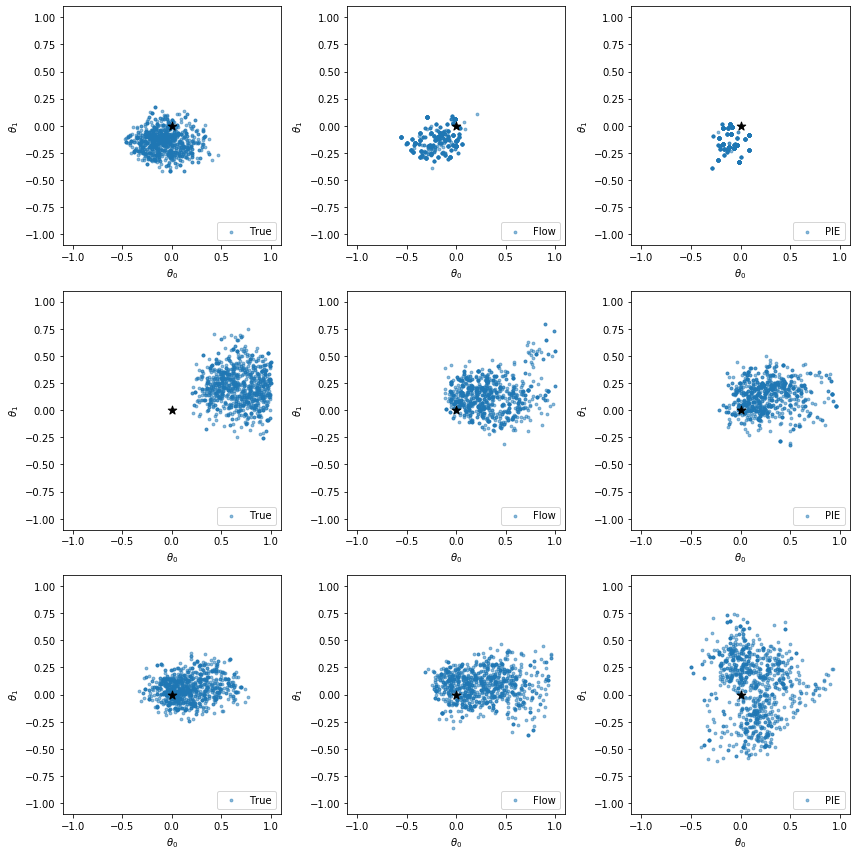

In [11]:
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(["True"] + algo_labels):
        ax = plt.subplot(nrows, ncols, row*ncols + col + 1)

        if col == 0:
            plt.scatter(
                true_posterior_samples[col, setting,:,0],
                true_posterior_samples[col, setting,:,1],
                s=8., alpha=0.5, c="C0",
                label=algo_label
            )
        else:
            plt.scatter(
                model_posterior_samples[col - 1, setting,:,0],
                model_posterior_samples[col - 1, setting,:,1],
                s=8., alpha=0.5, c="C0",
                label=algo_label
            )
        plt.scatter([0.], [0.], s=80, marker="*", c="black")
        plt.legend(loc="lower right")
        
        plt.xlabel(r"$\theta_0$")
        plt.ylabel(r"$\theta_1$")
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
    
plt.tight_layout()
plt.savefig("../figures/posterior_samples_csg.pdf")


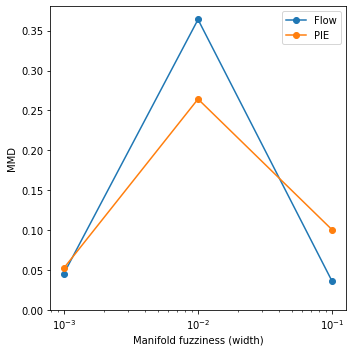

In [12]:
show = [1, 0, 2]
xs = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(5,5))

for mmds_, algo_label in zip(mmds, algo_labels):
    plt.plot(xs, mmds_[show], label=algo_label, ls="-", marker="o", ms=6.)
plt.legend()

plt.xscale("log")
plt.ylim(0., None)
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("MMD")

plt.tight_layout()
plt.savefig("../figures/posterior_metrics_csg.pdf")
